In [1]:
import iris
import iris.plot as iplt

import numpy
import matplotlib.pyplot as plt

from decimal import Decimal
import os, sys
cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
import convenient_universal as uconv

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
%matplotlib inline

In [8]:
def calc_anomaly(cube):
    """Calculate the anomaly."""
    
    anomaly = cube.copy()
    anomaly.data = anomaly.data - anomaly.data[0]
    anomaly = anomaly[-1, ::]
    anomaly.remove_coord('time')
    
    return anomaly

In [9]:
def inferred_wfo(s_orig, s_new, volume):
    """Calculate the inferred cumulative global total wfo for a given change in soga.
    
    wfo = net water flux into sea water
    soga = global mean sea water salinity
    v = volume of ocean (m3)
    
    """
    
    p = 1027  # kg/m3; average density of global ocean - could calculate from rhopoto data
    m_globe = volume * p
    
    delta_m = -1 * m_globe * (1 - (s_orig / s_new))    
    
    return delta_m

In [10]:
def change_budget_terms(model, experiment):
    """Calculate the freshwater change budget terms."""
    
    so_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/r1i1p1/so/latest/dedrifted/so-vertical-zonal-mean_Oyr_%s_%s_r1i1p1_all.nc' %(model, experiment, model, experiment)
    wfo_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/r1i1p1/wfo/latest/dedrifted/wfo-zonal-sum_Oyr_%s_%s_r1i1p1_cumsum-all.nc' %(model, experiment, model, experiment)
    volcello_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/fx/ocean/r0i0p0/volcello/latest/volcello-vertical-sum_fx_%s_historical_r0i0p0.nc' %(model, model)

    wfo_cube = iris.load_cube(wfo_file)
    so_cube = iris.load_cube(so_file)

    volume_cube = iris.load_cube(volcello_file)
    volume_zonal_sum = volume_cube.collapsed('longitude', iris.analysis.SUM)
    #print('global volume:', "{:.2e} m3".format(volume_zonal_sum.data.sum()))

    # Anomaly
    wfo_anomaly = calc_anomaly(wfo_cube)
    so_anomaly = wfo_anomaly.copy()
    so_anomaly.data = inferred_wfo(so_cube[0, ::].data, so_cube[-1, ::].data, volume_zonal_sum.data)
    
    ocean_convergence = so_anomaly - wfo_anomaly
    transport_anomaly = ocean_convergence.copy()
    transport_anomaly.data = numpy.ma.cumsum(-1 * ocean_convergence.data)
    
    return wfo_anomaly, so_anomaly, transport_anomaly


def clim_budget_terms(model, experiment, clim_bounds=None):
    """Calculate the freshwater climatology budget terms"""
    
    wfo_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/r1i1p1/wfo/latest/wfo-zonal-sum_Oyr_%s_%s_r1i1p1_all.nc' %(model, experiment, model, experiment)
    wfo_cube = iris.load_cube(wfo_file)

    if clim_bounds:
        start, end = clim_bounds
        wfo_clim = wfo_cube[start:end].collapsed('time', iris.analysis.MEAN)
    else:
        wfo_clim = wfo_cube.collapsed('time', iris.analysis.MEAN)
    
    transport_clim = wfo_clim.copy()
    transport_clim.data = numpy.ma.cumsum(wfo_clim.data)
    
    return wfo_clim, transport_clim
    
    
def plot_budget(model, experiment):
    """Plot the freshwater budget"""

    fig, axs = plt.subplots(1, 2, figsize=[16, 4])
    
    # Change
    wfo_anomaly, so_anomaly, transport_anomaly  = change_budget_terms(model, experiment)
    print('global wfo cumulative anomaly:', "{:.2e} kg".format(wfo_anomaly.data.sum()))
    print('global so cumulative anomaly:', "{:.2e} kg".format(so_anomaly.data.sum()))
    plt.sca(axs[0])
    plt.hlines(0, -85, 88, linestyles='--')
    iplt.plot(wfo_anomaly, color='orange', label='wfo')
    iplt.plot(so_anomaly, color='blue', label='wfo') 
    plt.title('Freshwater change (1850-2005)')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    #ax.yaxis.major.formatter._useMathText = True
    plt.xlabel('latitude')
    plt.ylabel('cumulative anomaly (kg)')
    
    # Climatology
    wfo_clim, transport_clim = clim_budget_terms(model, experiment)
    plt.sca(axs[1])
    plt.hlines(0, -85, 88, linestyles='--')
    iplt.plot(wfo_clim, color='orange', label='wfo')
    plt.title('wfo climatology')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    #ax.yaxis.major.formatter._useMathText = True
    plt.xlabel('latitude')
    plt.ylabel('total annual flux (kg)')
    
    plt.suptitle(model + ', ' + experiment)
    plt.show()

    
def plot_transport(model, experiment):
    """Plot the freshwater transport"""

    fig, axs = plt.subplots(1, 2, figsize=[16, 4])
    
    # Change
    wfo_anomaly, so_anomaly, transport_anomaly = change_budget_terms(model, experiment)
    
    transport_so_zero = wfo_anomaly.copy()
    transport_so_zero.data = numpy.ma.cumsum(wfo_anomaly.data)
    
    plt.sca(axs[0])
    plt.hlines(0, -85, 88, linestyles='--')
    iplt.plot(transport_anomaly, color='green', label='real salinity data')
    iplt.plot(transport_so_zero, color='green', linestyle='--', label='salinity set zero')
    title = 'Anomalous northward freshwater transport'
    plt.title(title)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    #ax.yaxis.major.formatter._useMathText = True
    plt.xlabel('latitude')
    plt.ylabel('cumulative transport (kg)')
    plt.legend()
    
    # Climatology
    wfo_clim, transport_clim = clim_budget_terms(model, experiment)
    plt.sca(axs[1])
    plt.hlines(0, -85, 88, linestyles='--')
    iplt.plot(transport_clim, color='green')
    plt.title('northward transport climatology (so = zero)')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    #ax.yaxis.major.formatter._useMathText = True
    plt.xlabel('latitude')
    plt.ylabel('total annual northward flux (kg)')
    
    plt.suptitle(model + ', ' + experiment)
    plt.show()

global wfo cumulative anomaly: 1.17e+16 kg
global so cumulative anomaly: 9.36e+15 kg


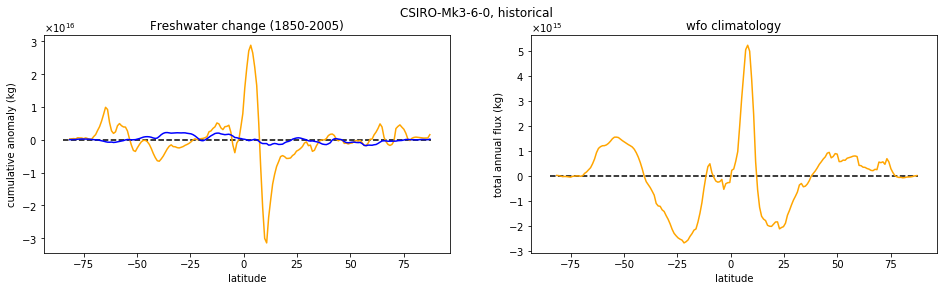

In [11]:
plot_budget('CSIRO-Mk3-6-0', 'historical')

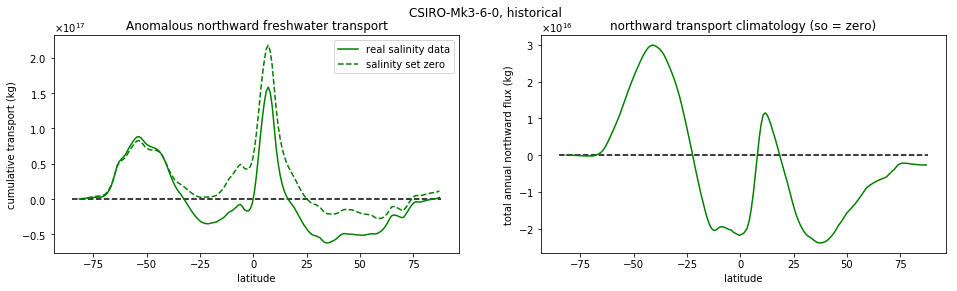

In [12]:
plot_transport('CSIRO-Mk3-6-0', 'historical')

global wfo cumulative anomaly: 8.33e+15 kg
global so cumulative anomaly: 1.03e+16 kg


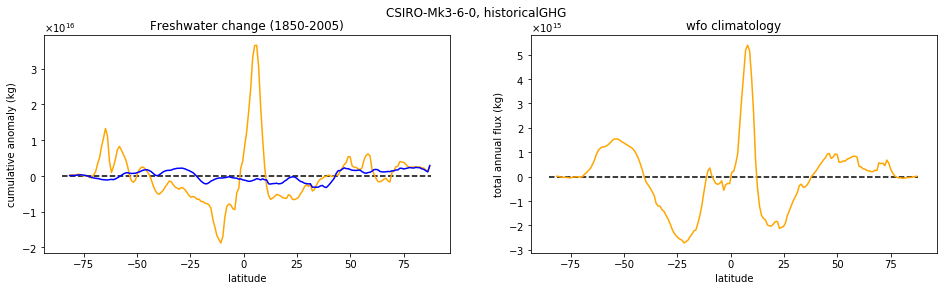

In [13]:
plot_budget('CSIRO-Mk3-6-0', 'historicalGHG')

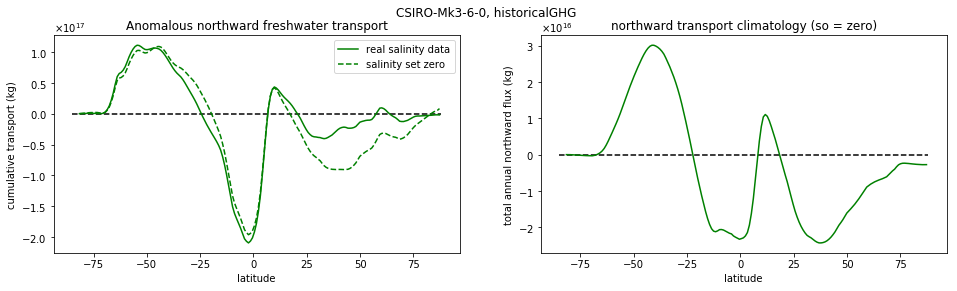

In [14]:
plot_transport('CSIRO-Mk3-6-0', 'historicalGHG')

In [15]:
wfo_anomaly_hist, so_anomaly_hist, transport_anomaly_hist = change_budget_terms('CSIRO-Mk3-6-0', 'historical')
wfo_anomaly_ghg, so_anomaly_ghg, transport_anomaly_ghg = change_budget_terms('CSIRO-Mk3-6-0', 'historicalGHG')
wfo_clim_hist_start, transport_clim_hist_start = clim_budget_terms('CSIRO-Mk3-6-0', 'historical', clim_bounds=[0, 10])
wfo_clim_hist_end, transport_clim_hist_end = clim_budget_terms('CSIRO-Mk3-6-0', 'historical', clim_bounds=[-10, -1])
wfo_clim_ghg_start, transport_clim_ghg_start = clim_budget_terms('CSIRO-Mk3-6-0', 'historicalGHG', clim_bounds=[0, 10])
wfo_clim_ghg_end, transport_clim_ghg_end = clim_budget_terms('CSIRO-Mk3-6-0', 'historicalGHG', clim_bounds=[-10, -1])

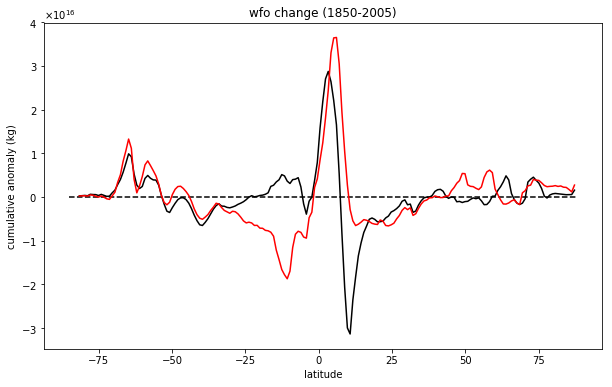

In [16]:
fig = plt.figure(figsize=[10, 6])
plt.hlines(0, -85, 88, linestyles='--')
iplt.plot(wfo_anomaly_hist, color='black', label='historical')
iplt.plot(wfo_anomaly_ghg, color='red', label='GHG-only') 
plt.title('wfo change (1850-2005)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#ax.yaxis.major.formatter._useMathText = True
plt.xlabel('latitude')
plt.ylabel('cumulative anomaly (kg)')
plt.show()

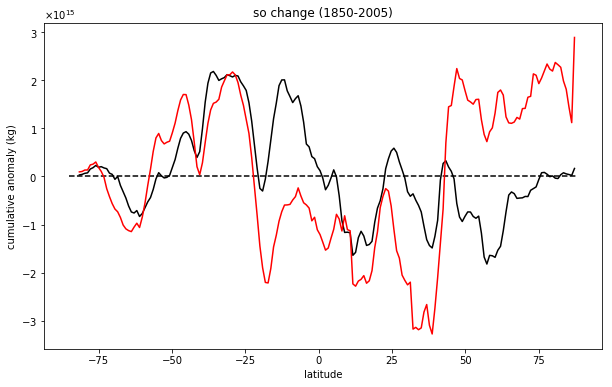

In [17]:
fig = plt.figure(figsize=[10, 6])
plt.hlines(0, -85, 88, linestyles='--')
iplt.plot(so_anomaly_hist, color='black', label='historical')
iplt.plot(so_anomaly_ghg, color='red', label='GHG-only') 
plt.title('so change (1850-2005)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#ax.yaxis.major.formatter._useMathText = True
plt.xlabel('latitude')
plt.ylabel('cumulative anomaly (kg)')
plt.show()

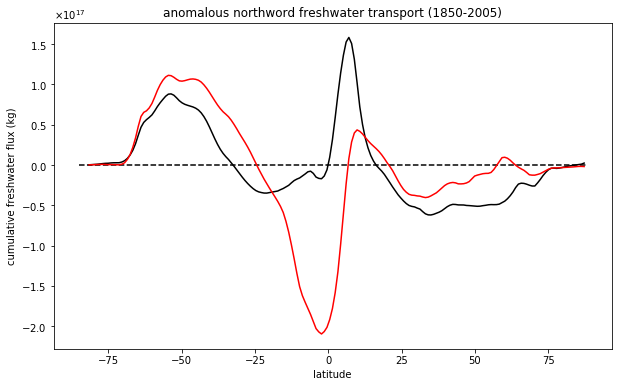

In [18]:
fig = plt.figure(figsize=[10, 6])
plt.hlines(0, -85, 88, linestyles='--')
iplt.plot(transport_anomaly_hist, color='black', label='historical')
iplt.plot(transport_anomaly_ghg, color='red', label='GHG-only') 
plt.title('anomalous northword freshwater transport (1850-2005)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#ax.yaxis.major.formatter._useMathText = True
plt.xlabel('latitude')
plt.ylabel('cumulative freshwater flux (kg)')
plt.show()

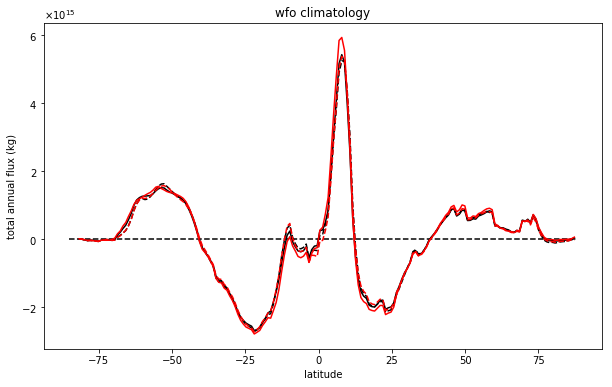

In [19]:
fig = plt.figure(figsize=[10, 6])
plt.hlines(0, -85, 88, linestyles='--')
iplt.plot(wfo_clim_hist_end, color='black', label='historical')
iplt.plot(wfo_clim_hist_start, color='black', linestyle='--')
iplt.plot(wfo_clim_ghg_end, color='red', label='historical')
iplt.plot(wfo_clim_ghg_start, color='red', linestyle='--')
plt.title('wfo climatology')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xlabel('latitude')
plt.ylabel('total annual flux (kg)')
plt.show()

## Matching so and soga

In [152]:
raw_soga_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/soga/latest/soga_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_all.nc'
raw_soga_cube = iris.load_cube(raw_soga_file)

In [153]:
raw_vm_so_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/so/latest/so-vertical-mean_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_185001-185912.nc'
raw_vm_so_cube = iris.load_cube(raw_vm_so_file)

In [154]:
raw_vzm_so_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/so/latest/so-zonal-vertical-mean_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_all.nc'
raw_vzm_so_cube = iris.load_cube(raw_vzm_so_file)

In [155]:
volume_cube = iris.load_cube('/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/fx/ocean/r0i0p0/volcello/latest/volcello-vertical-sum_fx_CSIRO-Mk3-6-0_historical_r0i0p0.nc')

In [156]:
volume_vs_weights = uconv.broadcast_array(volume_cube.data, [1, 2], raw_vm_so_cube.shape)
inferred_vm_soga = raw_vm_so_cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN, weights=volume_vs_weights)

In [157]:
volume_vzs_cube = volume_cube.collapsed('longitude', iris.analysis.SUM)
volume_vzs_weights = uconv.broadcast_array(volume_vzs_cube.data, 1, raw_vzm_so_cube.shape)
inferred_vzm_soga = raw_vzm_so_cube.collapsed('latitude', iris.analysis.MEAN, weights=volume_vzs_weights)

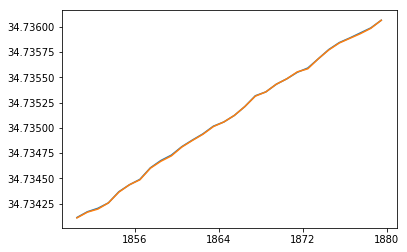

In [167]:
fig, ax = plt.subplots()
iplt.plot(raw_soga_cube[0:30])
#iplt.plot(inferred_vm_soga)
iplt.plot(inferred_vzm_soga[0:30])
ax.yaxis.major.formatter._useOffset = False
plt.show()

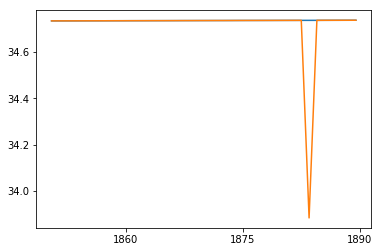

In [168]:
fig, ax = plt.subplots()
iplt.plot(raw_soga_cube[0:40])
#iplt.plot(inferred_vm_soga)
iplt.plot(inferred_vzm_soga[0:40])
ax.yaxis.major.formatter._useOffset = False
plt.show()

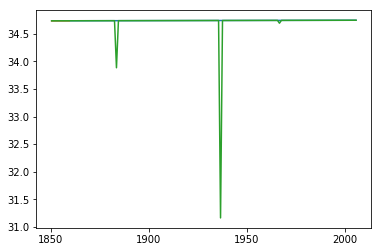

In [169]:
fig, ax = plt.subplots()
iplt.plot(raw_soga_cube)
iplt.plot(inferred_vm_soga)
iplt.plot(inferred_vzm_soga)
ax.yaxis.major.formatter._useOffset = False
plt.show()

So there doesn't appear to be a problem with how I'm integrating the salinity data (i.e. using volume weighted means).
The problem must therefore be with the dedrifting... In partcular, the drfited soga timeseries does not match the global sum of the dedrifted zonal mean salinity timeseries. It should. 

Perhaps the crazy values at some point are messing things up.